# LandSat-8 L2 true color visualization & land cover classification

This exercise is divided into 2 parts.

The first one, aims to obtain an RGB composition using a LandSat-8 L2 product downloaded from https://earthexplorer.usgs.gov/. 
For the composition, band 2 (blue), 3 (green) and 4 (red) are used. These bands are uint16 types and when they are used with the imshow function from matplotlib, they have to be converted to float or uint8. For that reason, a normalization is applied.
In order that our composition does not to look "hazy" or "too dark", a linear stretch is applied to the histogram. 

The second part aims to obtain a land cover classification using a python Machine Learning library scikit-learn.


### Part 1: RGB composite

In [1]:
import rasterio #reads raster images into numpy arrays
import numpy as np 
import matplotlib.pyplot as plt #plots RGB compositions. The imshow function only accepts uint8 or float types.
from skimage import exposure 

In [2]:
# Define the path where the data is found:

red_path = r"C:\landsat8_L2\LC08_L1TP_196030_20200224_20200224_01_RT_sr_band4.tif"
green_path = r"C:\landsat8_L2\LC08_L1TP_196030_20200224_20200224_01_RT_sr_band3.tif"
blue_path = r"C:\landsat8_L2\LC08_L1TP_196030_20200224_20200224_01_RT_sr_band2.tif"

In [3]:
# This definition finds the minimum and maximum value for each band, and returns the normalised values [0,1]. 

def norm(band):
    band_min, band_max = np.min(band), np.max(band)
    return ((band - band_min)/(band_max - band_min))

In [4]:
# Open bands and set noData (-9999), <0 and >10,000 values to 0 (see valid range from the LS8 surface reflectance specifications).

with rasterio.open(red_path) as red, rasterio.open(green_path) as green, rasterio.open(blue_path) as blue:
    npred = red.read(1,out_dtype=np.float,fill_value=-9999,boundless=True)
    npred[npred>=10000]=-9999
    npred[npred<=0]=0
    
    npgreen = green.read(1,out_dtype=np.float,fill_value=-9999,boundless=True)
    npgreen[npgreen>=10000]=-9999
    npgreen[npgreen<=0]=0

    npblue = blue.read(1,out_dtype=np.float,fill_value=-9999,boundless=True)
    npblue[npblue>=10000]=-9999
    npblue[npblue<=0]=0

data = np.array([norm(npred), norm(npgreen), norm(npblue)])

del npred, npgreen, npblue

In [5]:
rgb = np.dstack(data) # numpy dstack creates a 3D matrix with one dimension per band matrix

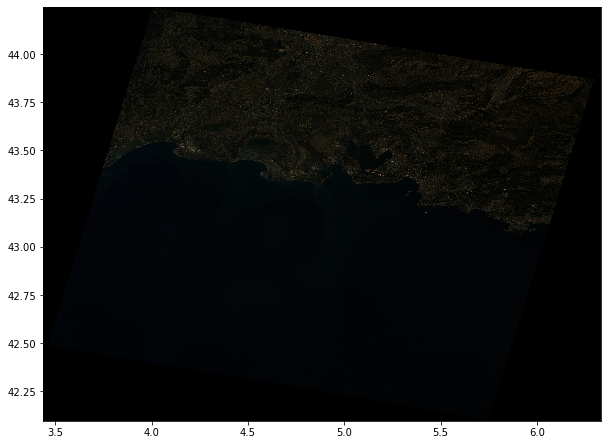

In [6]:
plt.figure(figsize = (10, 10))
plt.imshow(rgb, extent = [3.436685 , 6.331532, 42.097202 , 44.246178]) #xmin, xmax, ymin, ymax from metadata.

In [7]:
rgb_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]]) #reshapes the 3D matrix to 2D.

In [8]:
print(data.shape)
print(rgb.shape)
print(rgb_vector.shape)

(3, 7791, 7671)
(7791, 7671, 3)
(23373, 7671)


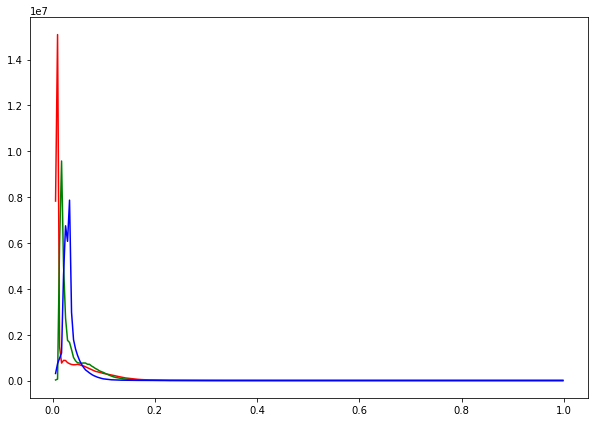

In [9]:
# View histogram of RGB values. 
# If the data has NaNs, they need to be removed: rgb_vector = rgb_vector[~np.isnan(rgb_vector).any(axis=1)]

fig = plt.figure(figsize=(10, 7))
for color, channel in zip('rgb_vector', np.rollaxis(rgb, axis=-1)):
    counts, centers = exposure.histogram(channel)
    plt.plot(centers[1::], counts[1::], color=color)
plt.show()

In [10]:
# Definition that applies a linear stretch of 1.25% to the histogram

def linearStretch(input, percent):
    pLow, pHigh = np.percentile(input[~np.isnan(input)], (percent, 100 - percent))
    img_rescale = exposure.rescale_intensity(input, in_range=(pLow, pHigh))
    return img_rescale

In [11]:
img_rescaled = linearStretch(rgb, 1.25) #change percentage here if needed

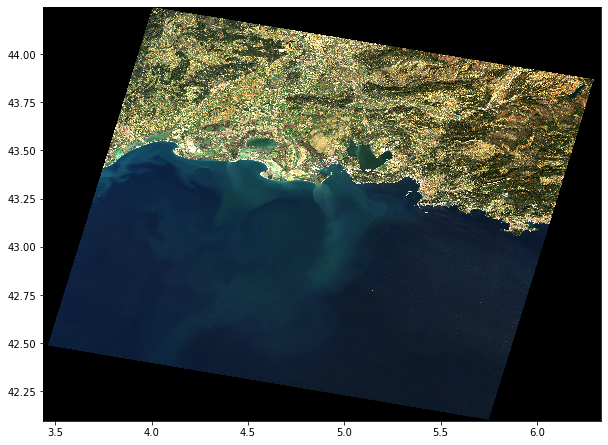

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(img_rescaled, extent = [3.436685 , 6.331532, 42.097202 , 44.246178]) 

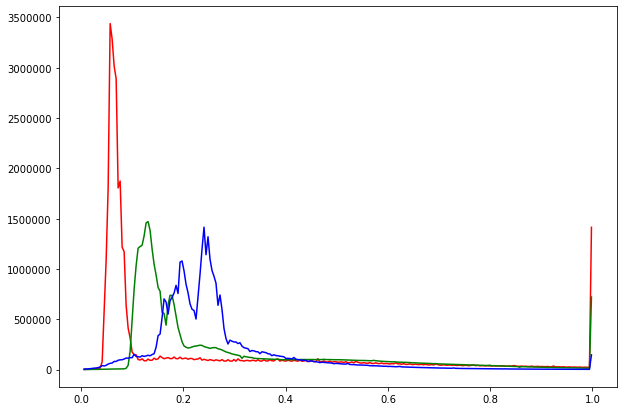

In [13]:
# Histogram after applying linear stretch

fig = plt.figure(figsize=(10, 7))
for color, channel in zip('rgb_vector', np.rollaxis(img_rescaled, axis=-1)):
    counts, centers = exposure.histogram(channel)
    plt.plot(centers[1::], counts[1::], color=color)
plt.show()

### Part 2: Land cover classification

In [34]:
import sklearn.cluster

In [35]:
samples = data.reshape((3, -1)).T
samples.shape

(59764761, 3)

In [36]:
clf = sklearn.cluster.KMeans(n_clusters=4)

In [37]:
labels = clf.fit_predict(samples)
labels.shape

(59764761,)

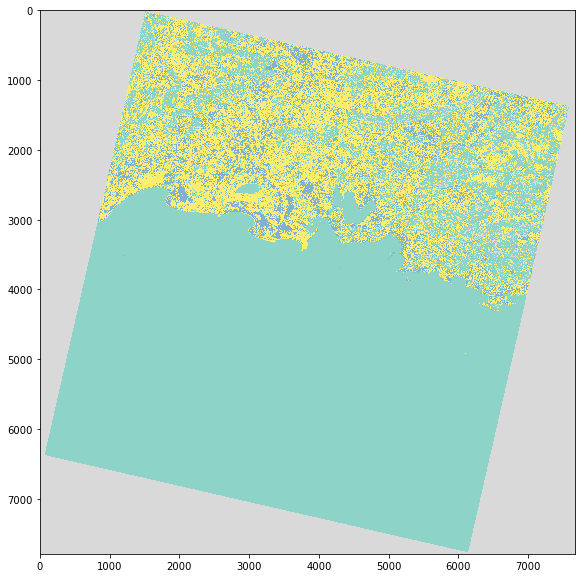

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(labels.reshape((7791, 7671)), cmap="Set3")